In [1]:
import numpy as np
from matplotlib import pyplot as plt
import netCDF4 as ncf
import pandas as pd
from datetime import datetime, timedelta

In [2]:
# import data

# velocity
# import inverted velocities

fn = '/home/martin/projects/Hubbard2024/velocity/hubbard_inversion_2015-10-01_2023-01-01.nc'
data = ncf.Dataset(fn)
vx = np.array(data.variables['vx'][:])
vy = data.variables['vy'][:]
v = np.sqrt(vx**2+vy**2)
t = data.variables['time'][:]
# units: seconds since 2015-10-22 15:31:58
x = np.array(data.variables['x'][:])
y = np.array(data.variables['y'][:])

# choose a point for velocity

x0 = -3.311e6
y0 = 258000

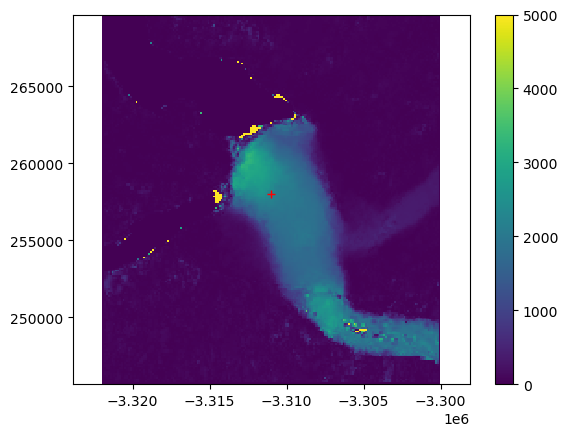

In [3]:
plt.pcolormesh(x,y,v[100,:,:],vmin=0,vmax=5000)
plt.axis('equal')
plt.plot(x0,y0,'r+')
plt.colorbar()

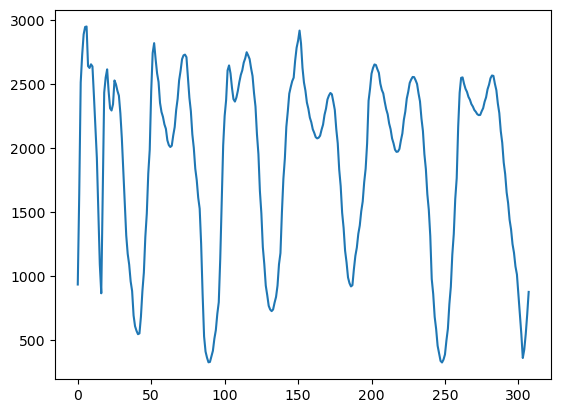

In [4]:
# extract velocity time series at point (x0,y0)

x_ind = np.argmin(np.abs(x-x0))
y_ind = np.argmin(np.abs(y-y0))

vel = v[:,y_ind,x_ind]

# interpolate to daily velocities 
# units: seconds since 2015-10-22 15:31:58
# create an array with daily velocities starting 1 June 2017 
spy = 86400*365 # seconds per year (non leap year)
spy_ly = 86400*366 # seconds per year (leap year)

# offset is time to 1 June 2017
offset = 2 + 28*60 + 8*3600 + (9+30+31)*86400 + spy_ly + (31+28+31+30+31)*86400
# end point Oct 31 2021
end_point = offset + (30+31+31+30+31+30+31)*86400 + 2*spy + spy_ly + (31+28+31+30+31+30+31+31+30+31)*86400

ti = np.arange(offset, end_point, 86400)

vi = np.interp(ti, t, vel)

t_dt = [datetime.strptime('2015-10-22 15:31:58', '%Y-%m-%d %H:%M:%S') + timedelta(seconds = int(i)) for i in ti]

#plt.plot(t_dt,vi)
plt.plot(vel)

In [5]:
# load terminus data

fn = '/home/martin/projects/Hubbard2024/terminus_change/terminus_speed_weather.csv'
df = pd.read_csv(fn)
term = df['terminus_advance_m'].to_numpy()
T = df['AirTempC_Yakutat_smooth'].to_numpy()
df['first_day'] = pd.Timestamp('20170501')
t_term = (pd.to_datetime(df['Date'])- df['first_day']).dt.days  # 0 is on May 1 2017
Delta_t = 31 # difference of when velocity time series starts (1 June 2017)

# create a time array from 1 May 2017 to 1 Dec 2021
total_days = 4*365 + 1 + 31+30+31+31+30+31+30 # 2020 is leap year
ti_term = np.arange(0, total_days, 1)
term_i = np.interp(ti_term, t_term, term)

Ti = np.interp(ti_term, t_term, T)

# create a cumulative PDD type graph that resets every year in October
may2oct = 31+30+31+31+30
jan2may = 31+29+31+30+11

pdd = np.zeros_like(Ti)
Ti[Ti<0] = 0
pdd[0:may2oct] = np.cumsum(Ti[0:may2oct])        # to Oct 2017
pdd[may2oct:may2oct+365] = np.cumsum(Ti[may2oct:may2oct+365])    # to Oct 2018
pdd[may2oct+365:may2oct+2*365] = np.cumsum(Ti[may2oct+365:may2oct+2*365])   # to Oct 2019
pdd[may2oct+2*365:may2oct+3*365] = np.cumsum(Ti[may2oct+2*365:may2oct+3*365])   # to Oct 2020
pdd[may2oct+3*365:may2oct+4*365] = np.cumsum(Ti[may2oct+3*365:may2oct+4*365]) # to Oct 2021

In [54]:
# function that produces a velocity time series

def vs(x, term, Delta_t, vi):
    [alpha, L_off, Delta_term, vmax, PDDmax] = x
    # create an array, starting with the velocity record in increments of 1 day
    N = len(vi)
    t_array=np.arange(N)
    #vterm = alpha*(term[t_array+Delta_t-int(Delta_term)]-L_off) + beta
    vterm = alpha*(term_i[t_array+Delta_t-int(Delta_term)]-L_off)
    vr = vmax*(1-(((2*PDDmax**2-pdd[t_array+Delta_t]**2)/(2*PDDmax**2))**2))
    #vr = vmax*(1-((pdd[t_array+Delta_t]-PDDmax)/PDDmax)**2)
    vr[vr<0] = 0
    
    return vr,vterm

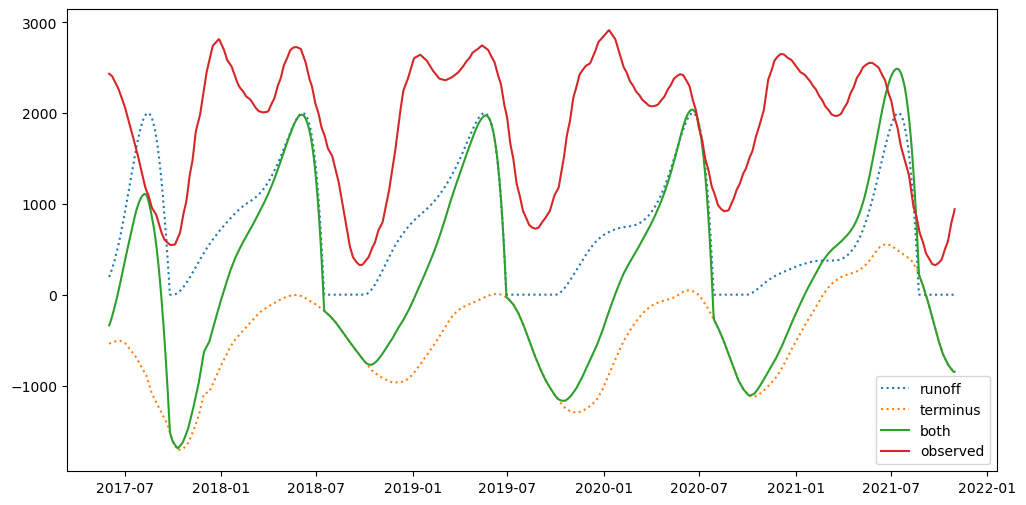

In [55]:
vr, vterm=vs([-6,100,0,2000,800],term_i, Delta_t, vi)

plt.figure(figsize=(12,6))
plt.plot(t_dt,vr, ':',label='runoff')
plt.plot(t_dt,vterm, ':', label='terminus')
plt.plot(t_dt,vterm+vr, label='both')
plt.plot(t_dt,vi, label='observed')
plt.legend()

In [62]:
# define a misfit function

def misfit(x,term, Delta_t, vi):
    [alpha, L_off, Delta_term, vmax, PDDmax] = x
    vr, vterm = vs([alpha, L_off, Delta_term, vmax, PDDmax],term, Delta_t, vi)
    vtot = vr+vterm
    # fit 2018 only, because cumulative runoff should include earlier data
    #return np.sum((vi[150:450]-vtot[150:450])**2)
    return np.sum((vi[150:]-vtot[150:])**2)
    #return np.sum((vi-vtot)**2)
          

In [63]:
from scipy.optimize import minimize
xmin = minimize(misfit, [2,0,20,1000,1000], args=(term, Delta_t, vi), method='Nelder-Mead', tol=1e-6, options={'maxiter':10000})
xmin

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 287107922.80645776
             x: [ 7.192e+00 -1.761e-02  7.100e+01  1.599e+03  8.619e+02]
           nit: 2089
          nfev: 3556
 final_simplex: (array([[ 7.192e+00, -1.761e-02, ...,  1.599e+03,
                         8.619e+02],
                       [ 7.192e+00, -1.761e-02, ...,  1.599e+03,
                         8.619e+02],
                       ...,
                       [ 7.192e+00, -1.761e-02, ...,  1.599e+03,
                         8.619e+02],
                       [ 7.192e+00, -1.761e-02, ...,  1.599e+03,
                         8.619e+02]]), array([ 2.871e+08,  2.871e+08,  2.871e+08,  2.871e+08,
                        2.871e+08,  2.871e+08]))

<Figure size 1200x600 with 0 Axes>

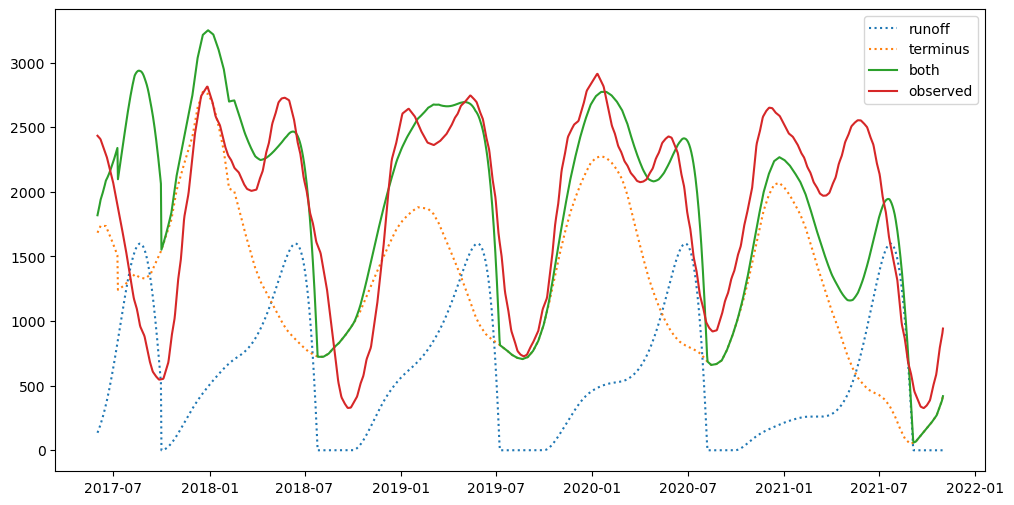

In [64]:
plt.figure(figsize=(12,6))
vr, vterm = vs(xmin['x'],term, Delta_t, vi)
v_tot = vr+vterm
plt.figure(figsize=(12,6))
plt.plot(t_dt,vr, ':', label='runoff')
plt.plot(t_dt,vterm, ':', label='terminus')
plt.plot(t_dt,vterm+vr, label='both')
plt.plot(t_dt,vi, label='observed')
plt.legend()
plt.savefig('simple_model.png')

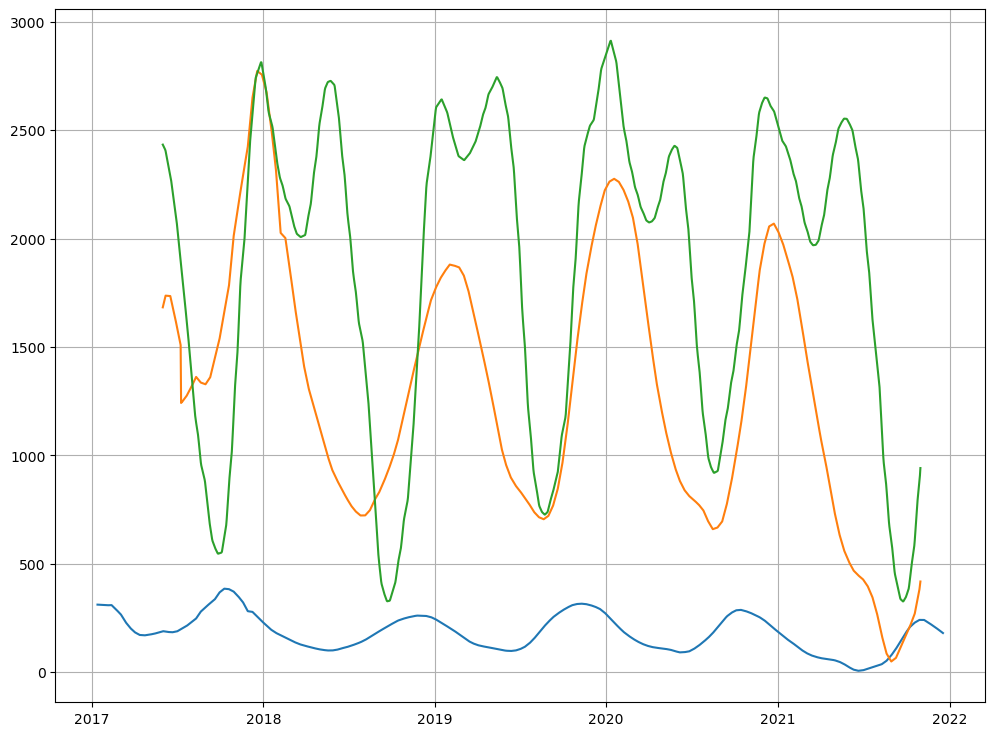

In [65]:
plt.figure(figsize=(12,9))
plt.plot(pd.to_datetime(df['Date']), term)
plt.plot(t_dt, vterm)
plt.plot(t_dt, vi)
plt.grid()

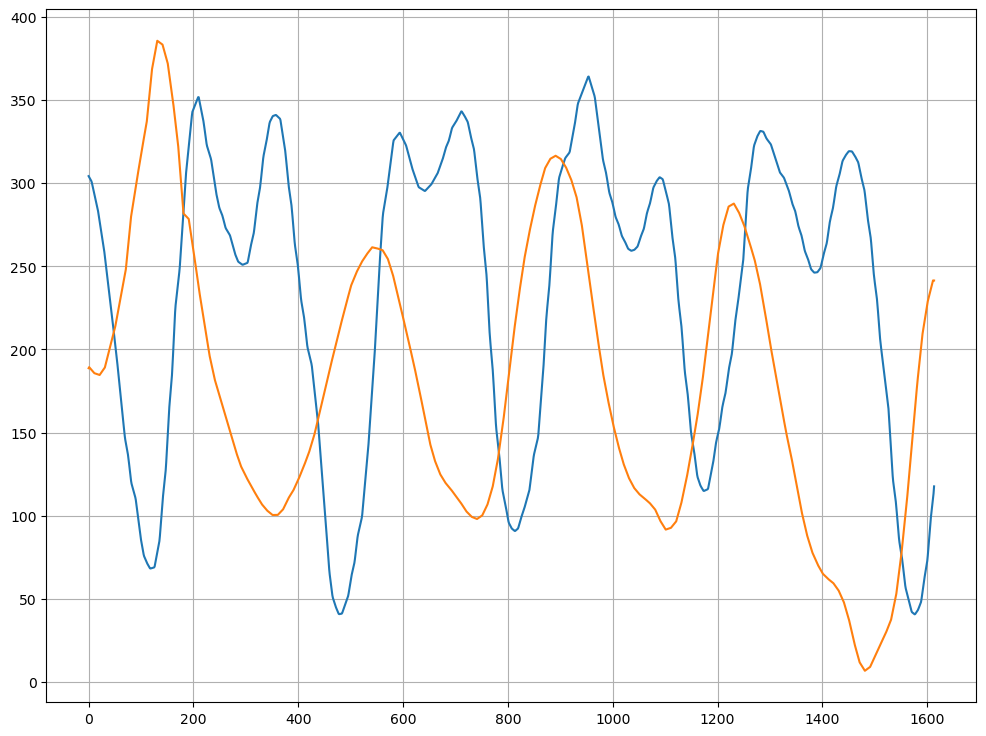

In [67]:
plt.figure(figsize=(12,9))
N = len(vi)
t_array=np.arange(N)
plt.plot(t_array,vi[t_array]/8)
plt.plot(t_array,term_i[t_array+Delta_t])
plt.grid()
#plt.plot(term[t_array])

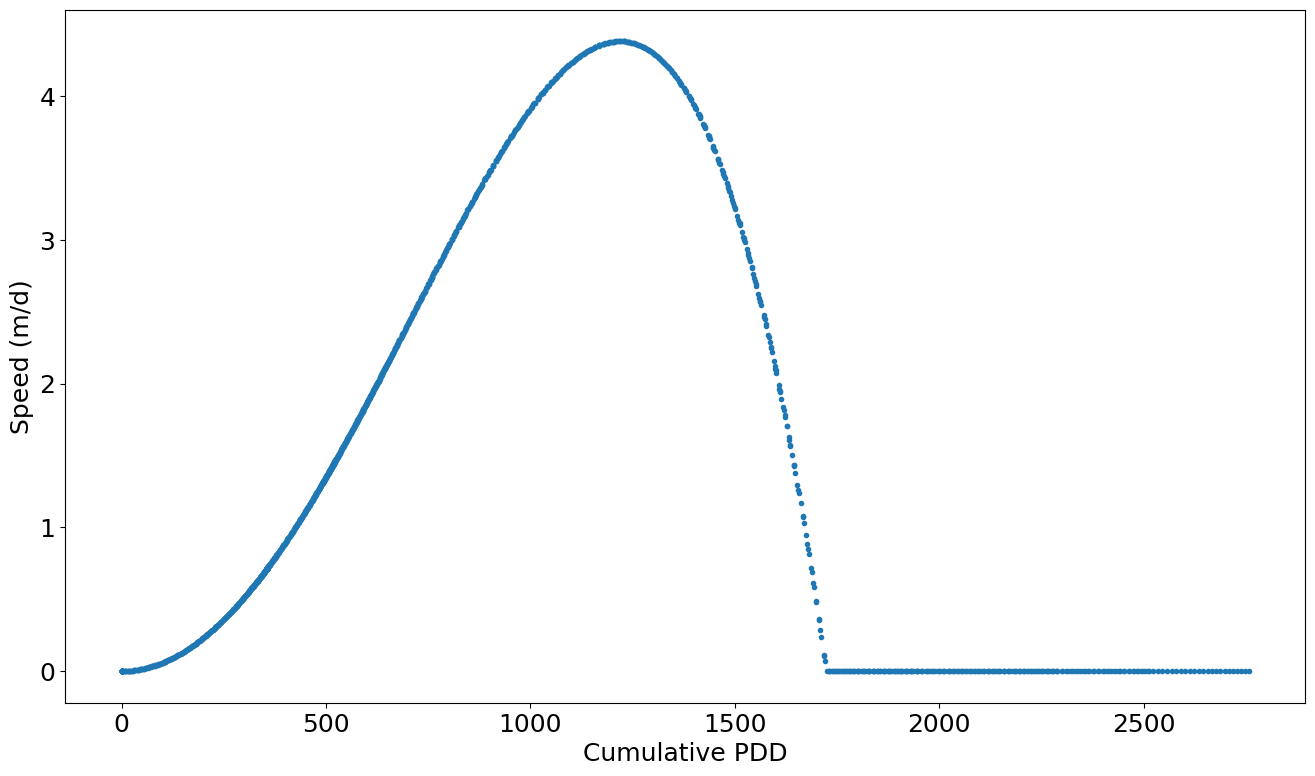

In [69]:
[alpha, L_off, Delta_term, vmax, PDDmax] = xmin['x']

def asym(x):
    return vmax*(1-(((2*PDDmax**2-x**2)/(2*PDDmax**2))**2))

f = asym(pdd)
f[f<0]=0

fig = plt.figure(figsize=(16,9))
plt.plot(pdd,f/365,'.')

plt.ylabel('Speed (m/d)', fontsize=18)
plt.xlabel('Cumulative PDD', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('pdd.png')

In [70]:
np.size(term)

1801

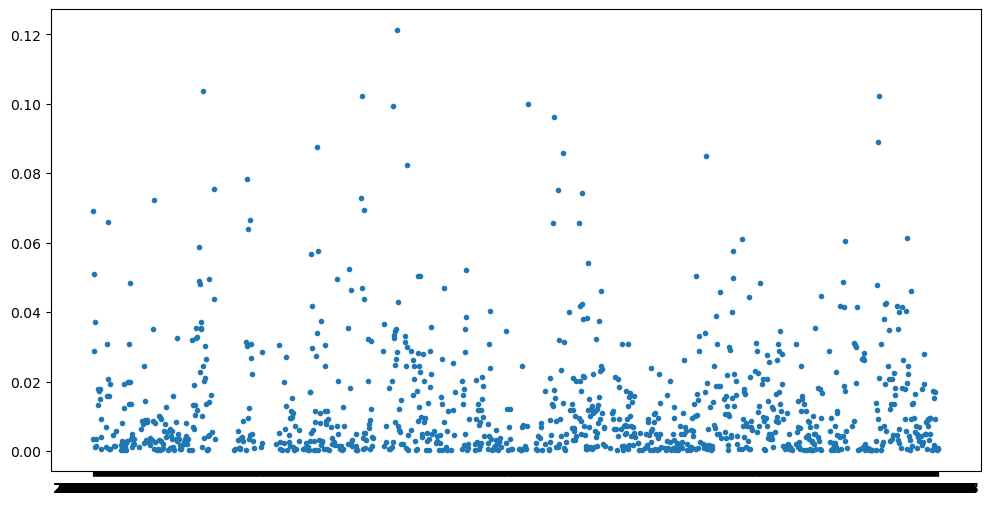

In [71]:
plt.figure(figsize=(12,6))
plt.plot(df['Date'],df['Precip_Yakutat'],'.')

In [32]:
points = pd.read_csv("../../velocity/centerline_points_100m.csv")
lags = np.zeros(len(points))

def find_lags(points):
    
    xp = points['X'].to_numpy()[20:140]
    yp = points['Y'].to_numpy()[20:140]
    k = 0
    for xi,yi in zip(xp,yp):
        
        # extract velocity time series at point (x0,y0)

        x_ind = np.argmin(np.abs(x-xi))
        y_ind = np.argmin(np.abs(y-yi))

        vel = v[:,y_ind,x_ind]
        vi = np.interp(ti, t, vel)
        
        xmin = minimize(misfit, [2,0,20,1000,1000], args=(term, Delta_t, vi), method='Nelder-Mead', tol=1e-6, options={'maxiter':10000})
        lags[k] = xmin['x'][3]
        k += 1
        
    return lags

lags = find_lags(points)
plt.plot(lags)

IndexError: index 1675 is out of bounds for axis 0 with size 1675

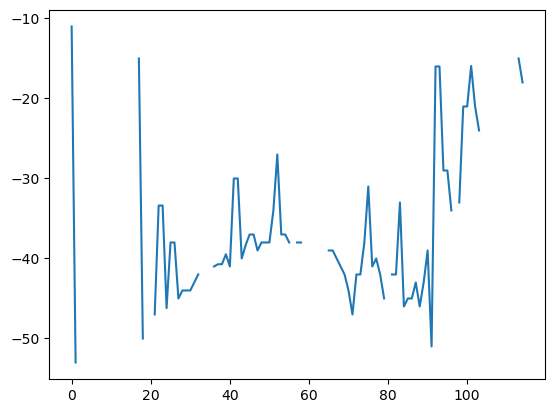

In [51]:
lags[lags>-10] = np.nan
plt.plot(lags)

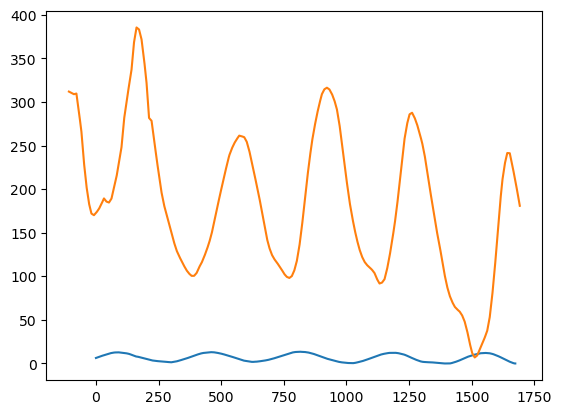

In [21]:
plt.plot(ti_term, Ti)
plt.plot(t_term, term)

In [73]:
1/917

0.0010905125408942203

In [31]:
128.2147-1.315e-6*265**3+2.4837e-8*265**4-1.6064e-10*265**5+4.6097e-13*265**6-4.9661e-16*265**7

130.3600637287323

In [72]:
4.52**2*np.sin(120/180*np.pi)


17.693245409477594